# 3F2 FTR Calculations

In [1]:
import numpy as np
from sympy import *
import control
from IPython.display import display
init_printing()

import matplotlib.pyplot as plt

In [2]:
# Select model to analyse: 0 for 'crane', 1 for 'inverted pendulum'
model = 1

## Controllability

A state-space system is *controllable* if given an initial state $\boldsymbol{x_0}$ and a final state $\boldsymbol{x_f}$, there exists and input signal $\boldsymbol{u}(\cdot)$ that transfers the state from $\boldsymbol{x}(0) = \boldsymbol{x_0}$ to $\boldsymbol{x}(T) = \boldsymbol{x_f}$ in a finite time $T>0$. By constructing the controllability matrix $P=[B|AB|...|A^{n-1}B]$ and checking it is full rank, we can test whether the system is controllable.

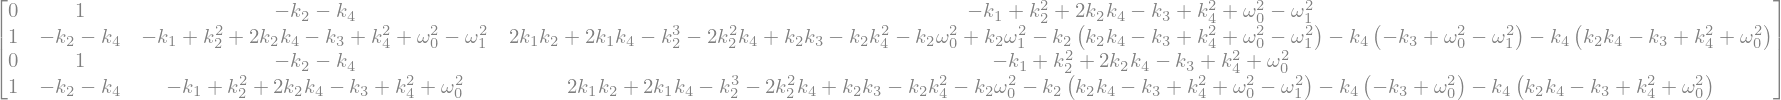

In [3]:
k1 = Symbol('k_1', real=True)
k2 = Symbol('k_2', real=True)
k3 = Symbol('k_3', real=True)
k4 = Symbol('k_4', real=True)

w0 = Symbol('omega_0', real=True)
w1 = Symbol('omega_1', real=True)

if model==0:
    A = Matrix([[0,1,0,0],[0,0,w1**2-w0**2,0],[0,0,0,1],[0,0,-w0**2,0]])
else:
    A = Matrix([[0,1,0,0],[0,0,w0**2-w1**2,0],[0,0,0,1],[0,0,w0**2,0]])
    
B = Matrix([0,1,0,1])
K = Matrix([[k1,k2,k3,k4]])

# controllability matrix
P = B
for i in range(len(K)-1):
    P = Matrix([[P,(A-B*K)**(i+1)*B]])    # Note the closed loop A matrix is (A-BK)

display(P)
display(P.det())


For the system to be controllable, $\det(P)=\omega_1^4 > 0$.

The poles of the system can be obtained by finding the eigenvalues of $(A-BK)$.

In [4]:
s = Symbol('s', complex=True)
I = eye(4)

# Closed loop characteristic equation
d_p = (s*I-A+B*K).det()
display(d_p.as_poly(s))             # display the CLCE as a polynomial of s
display(d_p.as_poly(s).coeffs())    # obtain the coefficients of s^n


##  Routh-Hurwitz Criterion
The Routh-Hurwitz criterion tests whether a polynomial has any roots with non-negative real parts. So
it tests for asymptotic stability.

$$p(s) = a_n s^n + a_{n-1}s^{n-1} + ... + a_0$$

for $n=4$, this holds iff all $a_i>0$ and $a_1 a_2 a_3 > a_0 a_3^2 + a_4a_1^2$

From the Sympy expressions above,
$$
\begin{align}
\textrm{Crane model} \qquad
&a_0:& k_{1} \omega_{1}^{2}\qquad
&a_1:& k_{2} \omega_{1}^{2}\qquad
&a_2:& k_{1} + k_{3} + \omega_{0}^{2}\qquad
&a_3:& k_{2} + k_{4}\qquad
&a_4:& 1\qquad \\
\textrm{Inverted model} \qquad
&a_0:& - k_{1} \omega_{1}^{2}\qquad
&a_1:& - k_{2} \omega_{1}^{2}\qquad
&a_2:& k_{1} + k_{3} - \omega_{0}^{2}\qquad
&a_3:& k_{2} + k_{4}\qquad
&a_4:& 1\qquad
\end{align}
$$

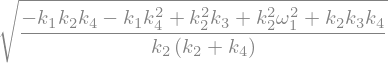

In [5]:
cfs = (d_p.as_poly(s).coeffs())[::-1]   # invert the list so that the coefficients match the indices

# Solve for w_0 when the last inequality from the Routh-Hurwitz test becomes an equality
freq = solve( (((cfs[1]*cfs[2]*cfs[3]) - (cfs[0]*cfs[3]**2 + cfs[4]*cfs[1]**2)) / (w1**2)), w0 )
display(freq[1])


Solving the equation for $\omega_0$, we obtain the below expressions.

For the crane model:
$$
\omega_0 = \sqrt{\frac{k_2 \omega_1^2}{k_2+k_4} + \frac{k_1 k_4 - k_2 k_3}{k_2}}
$$

For the inverted pendulum model:
$$
\omega_0 = \sqrt{\frac{k_2 \omega_1^2}{k_2+k_4} + \frac{k_2 k_3 - k_1 k_4}{k_2}}
$$

By ignoring the cubic terms in the square root expression, we can approximate the theoretical resonance frequency of the pendulum with the carriage free to move for both models as

$$
\begin{align*}
\hat{\omega} &= \sqrt{\frac{k_2}{k_2+k_4}} \omega_1 = \sqrt{\frac{k_2 g}{(k_2+k_4) L}} \\
% \omega_0 &= \sqrt{1 + \frac{m}{M+I/a^2}} \omega_1
\end{align*}
$$

We can also rearrange the above expression to obtain a theoretical value for $k_2$.

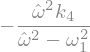

In [6]:
w_hat = Symbol('\hat{\omega}', real=True)
k2_hat = solve(  ( w_hat - sqrt((k2)/(k2+k4))*w1 ), k2  )

display(k2_hat[0])

Substituting the equations in section A.7, we can relate the resonance frequency of $\omega_0$
$$
k_2 = - \frac{\hat{\omega}^2 k_4}{\hat{\omega}^2 - \omega_1^2}
$$

## Sensitivity Analysis

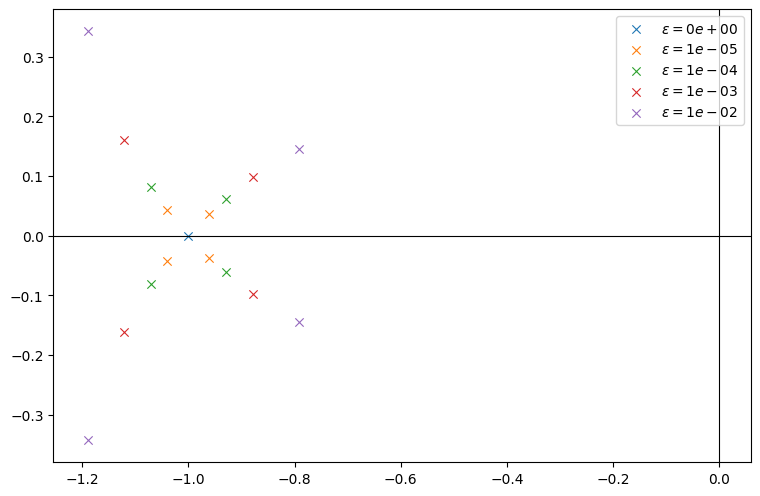

In [7]:
# Assume we have designed a controller with all poles set to -w1
CLCE = poly((s+w1)**4)

epsilon = [0, 1e-5 , 1e-4, 1e-3, 1e-2]

# We observe how the positions of the poles change with small changes in the coefficients of the CLCE. (only for the quartic term)
def find_shifted_poles(e):
    CLCE = poly((s+w1)**4 + e*s**4, domain='CC')

    poles = solve(CLCE, s)
    poles = [(pole/w1) for pole in poles]
    poles_re = [ re(pole) for pole in poles]
    poles_im = [ im(pole) for pole in poles]
    
    plt.scatter(poles_re, poles_im, marker='x', lw=0.8, label='$\epsilon = %0.0e$'%e)

plt.figure(figsize=(9, 6), dpi=100)
plt.axhline(0, color='k', lw=0.8)
plt.axvline(0, color='k', lw=0.8)

for e in epsilon:
    find_shifted_poles(e)
    
plt.legend(loc=1)
plt.show()


## Friction and Limit Cycles

We clarify some descriptions in the lab handout by plotting the functions.

* "Suppose that $\dot{x} = E \sin(\omega t)$, then $\textrm{sgn}(\dot{x})$ will be a square wave."
* $\textrm{sgn}(\dot{x})$ can be approximated by the first term in the Fourier series expansion.

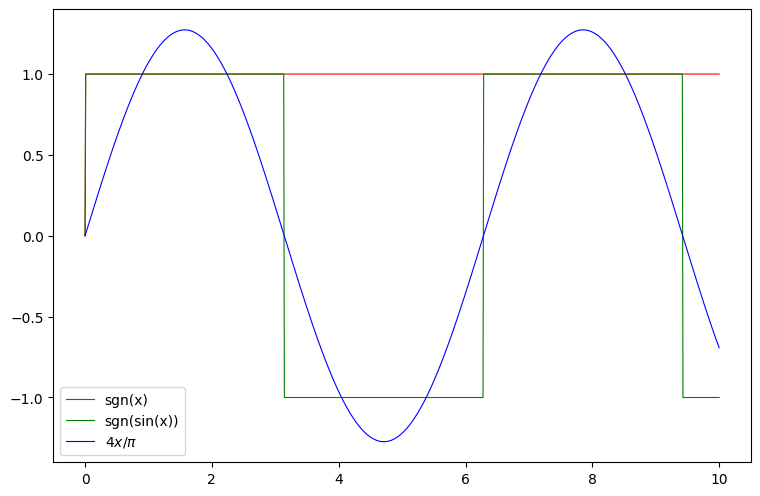

In [8]:
x = np.linspace(0,10,1000)

y1 = np.sign(x)
y2 = np.sign(np.sin(x))      # sgn(sin(x)) returns a square wave with period 2pi
y3 = 4/np.pi*np.sin(x)       # expand y2 with the Fourier series (only the first term)

plt.figure(figsize=(9, 6), dpi=100)
plt.plot(x, y1, '-r', lw=0.8, label = 'sgn(x)')
plt.plot(x, y2, '-g', lw=0.8, label = 'sgn(sin(x))')
plt.plot(x, y3, '-b', lw=0.8, label = '$4x/\pi$')

plt.legend()
plt.show()


* "The gain of the $\textrm{sgn}(\dot{x})$ nonlinearity increases quickly as the amplitude of $\dot{x}$ decreases."

Let's decipher what section A.6 is saying

1. The friction is modelled by $\textrm{sgn}(\dot{x})$.
2. When the system oscillates i.e. $\dot{x} = E \sin(\omega t)$;
3. the friction force is a step function (see the plot above).
4. The step function can be approximated by a sine function with amplitude $\frac{4}{\pi}$ from the first term of the Fourier series. Substitute the equation in step 2 to express $\sin(\omega t)$ in terms of $\dot{x}$.
$$
\textrm{sgn}(\dot{x}) \approx \frac{4}{\pi}\sin(\omega t) = \frac{4}{\pi E} \dot{x}
$$
5. In our dynamics model, there was a coefficient already multiplied to the $\textrm{sgn}(\dot{x})$ term. Combining with the scale factor above,
$$
\textrm{friction force} \quad f \sim \frac{4F}{\pi E (M + I/a^2)} \dot{x}
$$
6. Observing this expression, we see an inverse relation between the friction force and the amplitude of the input oscillation, $E$.

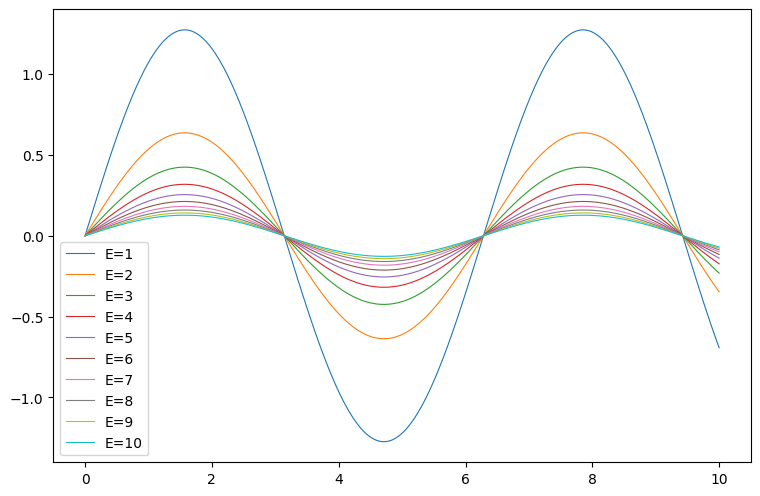

In [9]:
E_list = np.linspace(1,10,10)

friction_func = lambda E: 4/(np.pi*E)*np.sin(x)
friction = np.array([friction_func(e) for e in E_list])

plt.figure(figsize=(9, 6), dpi=100)

for i in range(len(E_list)):
    plt.plot(x, friction[i], lw=0.8, label = 'E=%d'%E_list[i])

plt.legend()
plt.show()


* "Therefore if an oscillation is present the friction term looks like an additional feedback gain from $\dot{x}$".

Now that we have a model of the friction force that is dependent on one of the states, $\dot{x}$, we can modify the $A$ matrix to account for the nonlinear friction force.

For the crane model:
$$
\begin{align*}
\left[\begin{matrix}
\dot{x}\\
\ddot{x}\\
L\dot{\theta}\\
L\ddot{\theta}
\end{matrix}\right]
&=
\left[\begin{matrix}0 & 1 & 0 & 0\\
0 & 0 & - \omega_{0}^{2} + \omega_{1}^{2} & 0\\
0 & 0 & 0 & 1\\
0 & 0 & - \omega_{0}^{2} & 0
\end{matrix}\right]
\left[\begin{matrix}x\\
\dot{x}\\
L\theta\\
L\dot{\theta}
\end{matrix}\right]
+
\left[\begin{matrix}
0\\
1\\
0\\
1
\end{matrix}\right]
(u-f) \\
&=
\left[\begin{matrix}
0 & 1 & 0 & 0\\
0 & -\frac{4F}{\pi E (M + I/a^2)} & - \omega_{0}^{2} + \omega_{1}^{2} & 0\\
0 & 0 & 0 & 1\\
0 & -\frac{4F}{\pi E (M + I/a^2)} & - \omega_{0}^{2} & 0
\end{matrix}\right]
\left[\begin{matrix}x\\\dot{x}\\L\theta\\L\dot{\theta}\end{matrix}\right]
+
\left[\begin{matrix}0\\1\\0\\1\end{matrix}\right]
u
\end{align*}
$$

For the inverted pendulum model:
$$
\begin{align*}
\left[\begin{matrix}
\dot{x}\\
\ddot{x}\\
L\dot{\theta}\\
L\ddot{\theta}
\end{matrix}\right]
&=
\left[\begin{matrix}0 & 1 & 0 & 0\\
0 & 0 & \omega_{0}^{2} - \omega_{1}^{2} & 0\\
0 & 0 & 0 & 1\\
0 & 0 & \omega_{0}^{2} & 0
\end{matrix}\right]
\left[\begin{matrix}x\\
\dot{x}\\
L\theta\\
L\dot{\theta}
\end{matrix}\right]
+
\left[\begin{matrix}
0\\
1\\
0\\
1
\end{matrix}\right]
(u-f) \\
&=
\left[\begin{matrix}
0 & 1 & 0 & 0\\
0 & -\frac{4F}{\pi E (M + I/a^2)} & \omega_{0}^{2} - \omega_{1}^{2} & 0\\
0 & 0 & 0 & 1\\
0 & -\frac{4F}{\pi E (M + I/a^2)} & \omega_{0}^{2} & 0
\end{matrix}\right]
\left[\begin{matrix}x\\\dot{x}\\L\theta\\L\dot{\theta}\end{matrix}\right]
+
\left[\begin{matrix}0\\1\\0\\1\end{matrix}\right]
u
\end{align*}
$$

With these new $A$ matrices, we follow the same analysis steps as before.

Note that the moment of inertia is denoted as $J$ in the Sympy code as the symbol $I$ is used for the Identity matrix.

In [10]:
F = Symbol('F', real=True)
E = Symbol('E', real=True)
M = Symbol('M', real=True)
J = Symbol('J', real=True)
a = Symbol('a', real=True)

friction_term = 4*F/(pi*E*(M+J/a**2))

if model==0:
    A = Matrix([[0,1,0,0],[0,-friction_term,w1**2-w0**2,0],[0,0,0,1],[0,-friction_term,-w0**2,0]])
else:
    A = Matrix([[0,1,0,0],[0,-friction_term,w0**2-w1**2,0],[0,0,0,1],[0,-friction_term,w0**2,0]])
    
P = B
for i in range(len(K)-1):
    P = Matrix([[P,(A-B*K)**(i+1)*B]])


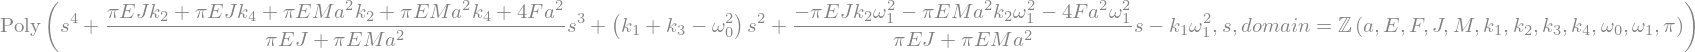

In [11]:
s = Symbol('s', complex=True)
I = eye(4)

# Closed loop characteristic equation
d_p = (s*I-A+B*K).det()
display(d_p.as_poly(s))

cfs = (d_p.as_poly(s).coeffs())[::-1]   # invert the list so that the coefficients match the indices

# Solve for w_0 when the last inequality from the Routh-Hurwitz test becomes an equality
freq = solve( (((cfs[1]*cfs[2]*cfs[3]) - (cfs[0]*cfs[3]**2 + cfs[4]*cfs[1]**2)) / (w1**2)), w0 )[1]

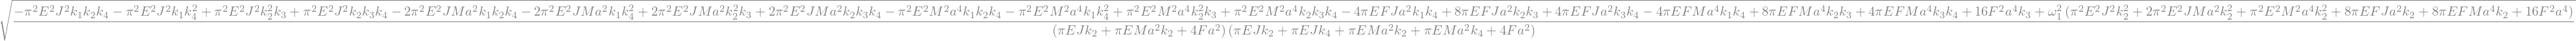

In [12]:
# Simplify and display the root by collecting w1 terms
display(collect(freq, w1))


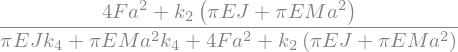

In [13]:
# Simplify terms
freq_hat_n = pi**2*E**2*J**2*k2**2 + 2*pi**2*E**2*J*M*a**2*k2**2 + pi**2*E**2*M**2*a**4*k2**2 + 8*pi*E*F*J*a**2*k2 + 8*pi*E*F*M*a**4*k2 + 16*F**2*a**4
freq_hat_d = (pi*E*J*k2 + pi*E*M*a**2*k2 + 4*F*a**2)*(pi*E*J*k2 + pi*E*J*k4 + pi*E*M*a**2*k2 + pi*E*M*a**2*k4 + 4*F*a**2)
freq_hat = freq_hat_n / freq_hat_d

display(collect(simplify(freq_hat), k2 ))


Ignoring cubic terms, we can approximate $\hat{\omega}$ as below. Just as before, the derived expression for $\hat{\omega}$ is the same in both models. (Verify by running the above cells with `model=1`)

$$
\begin{align*}
\hat{\omega} 
&= \sqrt{  \frac{4 F + k_{2} \left(\pi E (M + I/a^2)\right)}{4 F + (k_{2} + k_{4}) \left(\pi E (M + I/a^2)\right)}  } \omega_1 \\
&= \sqrt{  \frac{\gamma + k_{2} }{\gamma + (k_{2} + k_{4})}  } \omega_1 \\ \\
\textrm{where} \qquad \gamma &= \Delta k_2 = \frac{4 F}{\left(\pi (M + I/a^2)\right) E}
\end{align*}
$$

Substituting the values given in the handout and the measured moving friction force, $F = 1.226 \text{ N}$,
$$
\Delta k_2 \approx \frac{1.542}{E}
$$
